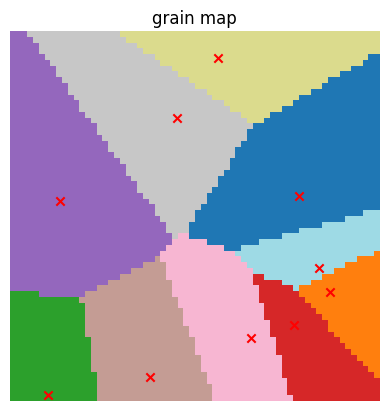

In [32]:
import numpy as np
import matplotlib.pyplot as plt


def make_grid(n):
    """pixel centers on unit square"""
    xs = np.linspace(0, 1, n, endpoint=False) + 0.5/n
    ys = np.linspace(0, 1, n, endpoint=False) + 0.5/n
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    return np.stack([X, Y], axis=-1)  # (n,n,2)

def assign_grains(n, K, rng):
    """very simple Voronoi-like labeling"""
    centers = rng.uniform(0,1,size=(K,2))
    grid = make_grid(n)

    # dist to each center
    diffs = grid[:,:,None,:] - centers[None,None,:,:]
    d2 = np.sum(diffs**2, axis=-1)   # (n,n,K)
    labels = np.argmin(d2, axis=-1)  # (n,n)
    return labels, centers



if __name__ == "__main__":
    n = 64
    K = 10
    rng = np.random.default_rng(42)

    labels, centers = assign_grains(n, K, rng)

    # visualize labels
    plt.imshow(labels, cmap="tab20")
    plt.scatter(centers[:,0]*n, centers[:,1]*n, c="red", marker="x")
    plt.title("grain map")
    plt.axis("off")
    plt.show()



In [5]:
import numpy as np
import matplotlib.pyplot as plt 
from dataclasses import dataclass
from typing import Dict,Tuple,Optional

In [ ]:
@dataclass
class PropertyRanges:
    """Material property ranges ."""
    E_min_GPa: float = 50.0
    E_max_GPa: float = 300.0
    nu_min: float = 0.2
    nu_max: float = 0.4
    xi0_min_MPa: float = 50.0
    xi0_max_MPa: float = 300.0
    h0_min_GPa: float = 0.0
    h0_max_GPa: float = 50.0


In [7]:
def _rng(seed: Optional[int]=None)->np.random.Generator:
    return np.random.default_rng(seed)

In [ ]:
def sample_grain_properties(K: int, pr: PropertyRanges, rng: np.random.Generator) -> Dict[str, np.ndarray]:
    E   = rng.uniform(pr.E_min_GPa, pr.E_max_GPa, size=K) * 1e9
    nu  = rng.uniform(pr.nu_min, pr.nu_max, size=K)
    xi0 = rng.uniform(pr.xi0_min_MPa, pr.xi0_max_MPa, size=K) * 1e6
    h0  = rng.uniform(pr.h0_min_GPa, pr.h0_max_GPa, size=K) * 1e9
    return {"E": E, "nu": nu, "xi0": xi0, "h0": h0}

In [9]:
@dataclass
class PropertyRanges:
    """Material property ranges ."""
    E_min_GPa: float = 50.0
    E_max_GPa: float = 300.0
    nu_min: float = 0.2
    nu_max: float = 0.4
    xi0_min_MPa: float = 50.0
    xi0_max_MPa: float = 300.0
    h0_min_GPa: float = 0.0
    h0_max_GPa: float = 50.0


In [10]:
def generate_voronoi_labels(n, K, rng):
    centers = rng.uniform(0, 1, size=(K, 2))
    xs = np.linspace(0, 1, n, endpoint=False) + 0.5/n
    ys = np.linspace(0, 1, n, endpoint=False) + 0.5/n
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    grid = np.stack([X, Y], axis=-1)

    diffs = grid[:, :, None, :] - centers[None, None, :, :]
    d2 = np.sum(diffs**2, axis=-1)
    labels = np.argmin(d2, axis=-1).astype(np.int32)
    return labels


In [11]:

def rasterize_properties(labels: np.ndarray, grain_props: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    
    prop_maps = {}
    for key, vec in grain_props.items():
        prop_maps[key] = vec[labels]
    return prop_maps

In [12]:
def build_input_tensor(prop_maps: Dict[str, np.ndarray]) -> np.ndarray:
    n = prop_maps["E"].shape[0]
    
    tensor = np.stack(
        [
            prop_maps["E"].astype(np.float32),
            prop_maps["nu"].astype(np.float32),
            prop_maps["xi0"].astype(np.float32),
            prop_maps["h0"].astype(np.float32),
            
        ],
        axis=-1,
    )
    return tensor

In [14]:
def generate_microstructure(
    n: int = 64,
    K: int = 10,
    prop_ranges: PropertyRanges = PropertyRanges(),
    seed: Optional[int] = None,
) -> Tuple[np.ndarray, Dict[str, np.ndarray], np.ndarray]:
    
    rng = _rng(seed)
    labels = generate_voronoi_labels(n, K, rng)
    grain_props = sample_grain_properties(K, prop_ranges, rng)
    prop_maps = rasterize_properties(labels, grain_props)
    tensor = build_input_tensor(prop_maps)
    return labels, prop_maps, tensor

In [15]:
def generate_dataset(
    N: int,
    n: int = 64,
    K: int = 10,
    prop_ranges: PropertyRanges = PropertyRanges(),
    seed: Optional[int] = None,
) -> np.ndarray:
    """
    Generate a dataset of N microstructures as a numpy array of shape (N, n, n, 5).
    """
    rng_master = _rng(seed)
    tensors = []
    for i in range(N):
        # Derive a seed per sample for reproducibility
        sample_seed = int(rng_master.integers(0, 2**31 - 1))
        _, _, tensor = generate_microstructure(n=n, K=K, prop_ranges=prop_ranges, seed=sample_seed)
        tensors.append(tensor)
    return np.stack(tensors, axis=0)

In [18]:
def show_microstructure(labels: np.ndarray) -> None:
    """Visualize grain labels."""
    plt.figure()
    plt.imshow(labels, interpolation='nearest')
    plt.title("Voronoi Grain Map (labels)")
    plt.axis('off')
    plt.show()


def show_property_map(name: str, arr: np.ndarray, unit: str) -> None:
    """Visualize a single property map with a colorbar."""
    plt.figure()
    im = plt.imshow(arr, interpolation='nearest')
    plt.title(f"{name} [{unit}]")
    plt.colorbar(im)
    plt.axis('off')
    plt.show()


def demo_visualization(seed: int = 42) -> Tuple[np.ndarray, Dict[str, np.ndarray], np.ndarray]:
    """
    Generate one sample and display:
      - grain labels
      - E (GPa), nu (-), xi0 (MPa), h0 (GPa)
      - von Mises initial (Pa, zeros)
    Returns the labels, property maps, and input tensor.
    """
    labels, props, tensor = generate_microstructure(seed=seed)
    show_microstructure(labels)
    
    # Display in friendly units for visualization
    show_property_map("Young's modulus E", props["E"] / 1e9, "GPa")
    show_property_map("Poisson's ratio ν", props["nu"], "-")
    show_property_map("Initial flow resistance ξ0", props["xi0"] / 1e6, "MPa")
    show_property_map("Linear isotropic hardening h0", props["h0"] / 1e9, "GPa")
    return labels, props, tensor

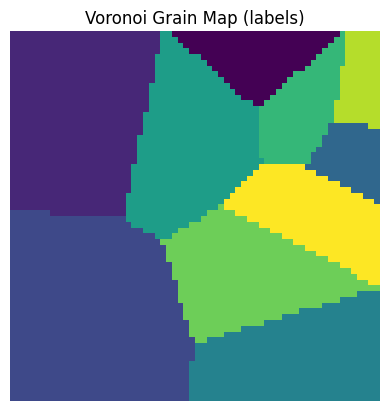

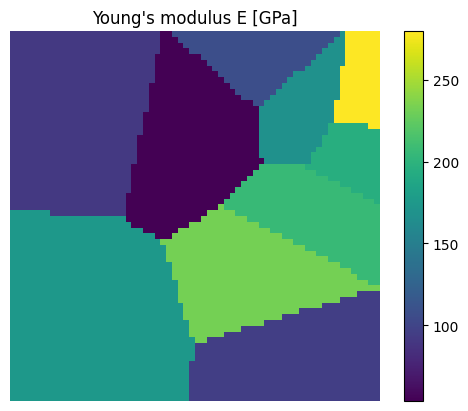

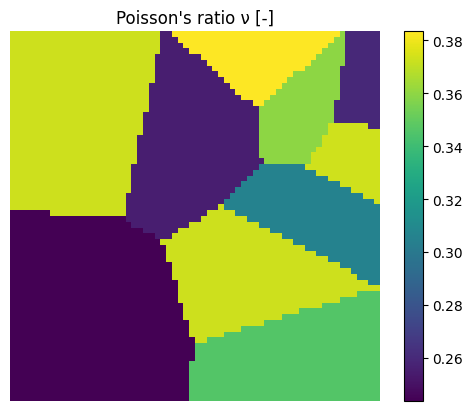

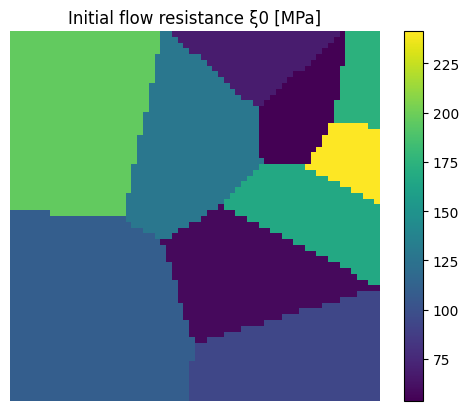

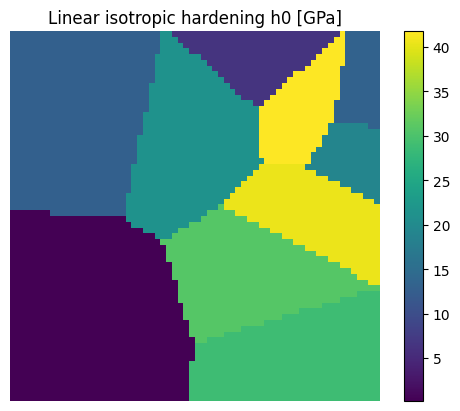

Dataset shape: (4, 64, 64, 4)


In [22]:
if __name__ == "__main__":
    # Generate and visualize a single microstructure
    labels, props, tensor = demo_visualization(seed=123)
    
    # Generate a small dataset (e.g., 4 samples)
    dataset = generate_dataset(N=4, seed=2025)
    print("Dataset shape:", dataset.shape)
